In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rasterio
!pip install openeo
!pip install pyshp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 64.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.7/219.7 kB 5.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.8 MB/s eta 0:00:00


In [ ]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import scipy.signal
import shapely.geometry
import pathlib

import openeo
from openeo.rest.job import RESTJob
from openeo.rest.conversions import timeseries_json_to_pandas

%matplotlib inline

In [ ]:
import re
import random
import shapefile
from shapely.geometry import shape, Point

import random
from shapely.affinity import affine_transform
from shapely.geometry import Point, Polygon
from shapely.ops import triangulate
from shapely.ops import unary_union

def random_points_in_polygon(polygon, k):
    "Return list of k points chosen uniformly at random inside the polygon."
    areas = []
    transforms = []
    for t in triangulate(polygon):
        areas.append(t.area)
        (x0, y0), (x1, y1), (x2, y2), _ = t.exterior.coords
        transforms.append([x1 - x0, x2 - x0, y2 - y0, y1 - y0, x0, y0])
    points = []
    for transform in random.choices(transforms, weights=areas, k=k):
        x, y = [random.random() for _ in range(2)]
        if x + y > 1:
            p = Point(1 - x, 1 - y)
        else:
            p = Point(x, y)
        points.append(affine_transform(p, transform))
    return points


def random_points_in_country(shp_location, country_name, num_points=20):
    shapes = shapefile.Reader(shp_location) # reading shapefile with pyshp library
    shapeRecs = shapes.shapeRecords()
    countries = [s for s in shapes.records() if country_name in s] # getting feature(s) that match the country name 
    country_ids = [int(re.findall(r'\d+', str(item))[0]) for item in countries] # getting feature(s)'s id of that match

    features = [shapeRecs[country_id].shape.__geo_interface__ for country_id in country_ids]
    shp_geoms = [shape(feature) for feature in features]
    shp_geom = unary_union(shp_geoms)
        
    points  = random_points_in_polygon(shp_geom, num_points)
    return [(p.y, p.x) for p in points]

In [ ]:
DEFAULT_FIGSIZE = (5, 4)

def show_tiff(filename:str, figsize=DEFAULT_FIGSIZE, vmin=None, vmax=None, rescale_percentile=97, add_colorbar=False):
    """Small helper to load a geotiff and visualize it"""
    with rasterio.open(filename) as ds:
        data = ds.read()

    fig, ax = plt.subplots(figsize=figsize)

    if len(data.shape) == 3:
        if data.max() > 500:
            p = np.percentile(data, rescale_percentile, axis=[1,2])
            data = data / p[:, None, None]
            data = np.clip(data, 0, 1)
        data = np.moveaxis(data, 0, 2)
        
    im = ax.imshow(data, vmin=vmin, vmax=vmax)
    if add_colorbar:
        fig.colorbar(im, ax=ax, fraction=0.05)

In [ ]:
assert os.path.exists('/content/drive/MyDrive/geoinformed'), 'no dir'
%cd /content/drive/MyDrive/geoinformed/resources

/content/drive/MyDrive/geoinformed/resources


In [ ]:
!ls

ne_10m_admin_1_states_provinces


In [ ]:
save_path = "/content/Flanders-Locations-3"
out_dir = pathlib.Path(save_path)
out_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
shp_location = "/content/drive/MyDrive/geoinformed/resources/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp"
assert os.path.exists(shp_location), "Input file does not exist."
location = 'Flemish Region'
points = random_points_in_country(shp_location, location, num_points=20)
print(points)

[(50.70323786448315, 4.6102972937144155), (50.77865090797564, 5.728994743059293), (50.838382395214325, 4.4439356544246245), (50.96425978099421, 5.600645137626089), (51.462109468035074, 4.82158468565062), (51.12351427291403, 2.919570073699053), (50.78655727036711, 4.433516100363594), (51.09871819613465, 4.096007068543278), (50.98496250310882, 3.8331872131432645), (50.696745813442526, 3.2725585025937733), (50.997962447883026, 4.667567768013796), (51.36334758772335, 3.597640859486019), (50.91330053157895, 4.8458421617329455), (51.269400654002595, 3.06283405071249), (50.80496585544539, 5.785668537199936), (50.91593977570311, 2.777402432871445), (51.143699325354866, 5.7551942072153865), (50.707975299646954, 5.4432134995885315), (50.70264941467039, 4.11080519285934), (50.94585150285959, 2.8913201955591044)]


In [ ]:
boundaries = []
for point in points:
    frame = {}
    frame['west'] = point[1] - 0.05
    frame['east'] = point[1] + 0.05
    frame['north'] = point[0] + 0.025
    frame['south'] = point[0] - 0.025
    frame["crs"] = "EPSG:4326"
    # frame["crs"] = "EPSG:31370"
    # frame["crs"] = "EPSG:32631"
    boundaries.append(frame)

In [19]:
print(boundaries)
with open("/content/drive/MyDrive/geoinformed/random_loc_coords.json", "w") as final:
    json.dump(boundaries, final)

[{'west': 4.560297293714416, 'east': 4.660297293714415, 'north': 50.72823786448315, 'south': 50.67823786448315, 'crs': 'EPSG:4326'}, {'west': 5.6789947430592935, 'east': 5.778994743059293, 'north': 50.80365090797564, 'south': 50.75365090797564, 'crs': 'EPSG:4326'}, {'west': 4.393935654424625, 'east': 4.493935654424624, 'north': 50.86338239521432, 'south': 50.813382395214326, 'crs': 'EPSG:4326'}, {'west': 5.5506451376260895, 'east': 5.650645137626089, 'north': 50.98925978099421, 'south': 50.93925978099421, 'crs': 'EPSG:4326'}, {'west': 4.7715846856506205, 'east': 4.87158468565062, 'north': 51.48710946803507, 'south': 51.437109468035075, 'crs': 'EPSG:4326'}, {'west': 2.869570073699053, 'east': 2.9695700736990527, 'north': 51.14851427291403, 'south': 51.09851427291403, 'crs': 'EPSG:4326'}, {'west': 4.383516100363594, 'east': 4.483516100363594, 'north': 50.81155727036711, 'south': 50.76155727036711, 'crs': 'EPSG:4326'}, {'west': 4.046007068543278, 'east': 4.146007068543278, 'north': 51.123

In [ ]:
eoconn = openeo.connect("openeo.vito.be").authenticate_oidc()

To authenticate: visit https://aai.egi.eu/device?user_code=DZSF-KQYA .
Authorized successfully.
Authenticated using device code flow.


In [ ]:
for i, bbox in enumerate(boundaries):
    bands = ["B04", "B03", "B02"]
    dates = ("2021-03-06", "2021-03-07")

    cube = eoconn.load_collection("TERRASCOPE_S2_TOC_V2", bands=bands)
    cube = cube.filter_bbox(bbox=bbox)
    cube = cube.filter_temporal(dates)

    cube.download(out_dir /f"location_{i}.tiff", format="GTIFF")
    show_tiff(out_dir / f"location_{i}.tiff")

Output hidden; open in https://colab.research.google.com to view.

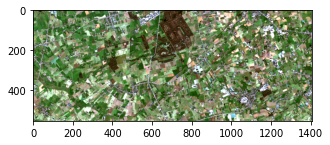

In [ ]:
show_tiff(out_dir / f"location_{i}.tiff")

In [ ]:
import json
import os

with open(os.path.join(out_dir, "random_locations_coordinates.json"), "w") as fp:
    json.dump(boundaries,fp) 

In [15]:
with open(r'/content/Flanders-Locations-3/loc_coords_20.txt', 'w') as fp:
    for item in boundaries:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done
